In [1]:
import networkx as nx
import pandas as pd
from tqdm import tqdm
from glob import glob
from collections import Counter

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
fp = fm.FontProperties(fname=font_path)

jsons = glob('tweets/*.json')
for i, f in enumerate(jsons):
    print(i,f)

0 tweets/#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
1 tweets/#ธรรมศาสตร์และการชุมนุม.json
2 tweets/#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
3 tweets/#25พฤศจิกาไปSCB.json
4 tweets/#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
5 tweets/#ม็อบ2ธันวา.json


In [3]:
df = pd.read_json(jsons[3], lines=True)

#df = df[df.reply_to.apply(len) > 0]
#df[['username','reply_to']]

df = df[df.mentions.apply(len) > 0]
df[['username','mentions']]

,username,mentions
9,opol999,"[{'screen_name': 'panusayas', 'name': 'panusay..."
13,lovedarkchoc2,"[{'screen_name': 'arnonnampa', 'name': 'อานนท์..."
14,lovedarkchoc2,"[{'screen_name': 'arnonnampa', 'name': 'อานนท์..."
15,lovedarkchoc2,"[{'screen_name': 'arnonnampa', 'name': 'อานนท์..."
16,lovedarkchoc2,"[{'screen_name': 'arnonnampa', 'name': 'อานนท์..."
...,...,...
48492,sanooknews,"[{'screen_name': 'paritchi', 'name': 'เพนกวิน ..."
48551,f_foam8,"[{'screen_name': 'wanaroonkandis', 'name': 'ka..."
48567,weeranan,"[{'screen_name': 'scb_thailand', 'name': 'scb ..."
48899,seefinish,"[{'screen_name': 'seefinish', 'name': '@seefin..."


In [4]:
reply = pd.DataFrame(columns=['replier','replyee'])

for i, row in df.iterrows():
    for dic in row['reply_to']:
            reply.loc[len(reply)] = [row['username'], dic['screen_name']]

In [6]:
set(reply.replier) & set(reply.replyee)

set()

In [7]:
edge_count = Counter()
for  j, i in zip(reply.replyee, reply.replier):
    edge_count[(i,j)] += 1
    
edge_count.most_common(5)

[(('kuro_noire_43', 'workpointTODAY'), 3),
 (('getar125', 'Maersk'), 2),
 (('malaimaimee', 'pick_pickmeup'), 1),
 (('malaimaimee', 'noname_8'), 1),
 (('malaimaimee', 'Thairath_News'), 1)]

In [8]:
node_count = {} # node: [replied, reply]
for i in reply.replyee:
    if i not in node_count:
        node_count[i] = [1,0]
    else:
        node_count[i][0] += 1
for i in reply.replier:
    if i not in node_count:
        node_count[i] = [0,1]
    else:
        node_count[i][1] += 1

# network

In [9]:
G = nx.DiGraph()  # Directed Graph

# add nodes
for node, tpl in node_count.items():
    if tpl[0] > tpl[1]:
        color = 'lightcoral'
    else:
        color = 'skyblue'
    G.add_node(node, color=color)
    
# add edges
G.add_weighted_edges_from([k+(v,) for k,v in edge_count.items()])

# ネットワーク全体の次数の平均値を計算
average_deg = sum(d for n, d in G.degree()) / G.number_of_nodes()

# ノードの次数に比例するようにサイズを設定
sizes = [300*deg/average_deg for node, deg in G.degree()]
edge_width = [d["weight"] * 1 for (u, v, d) in G.edges(data=True)]
node_color = [node["color"] for node in G.nodes.values()]

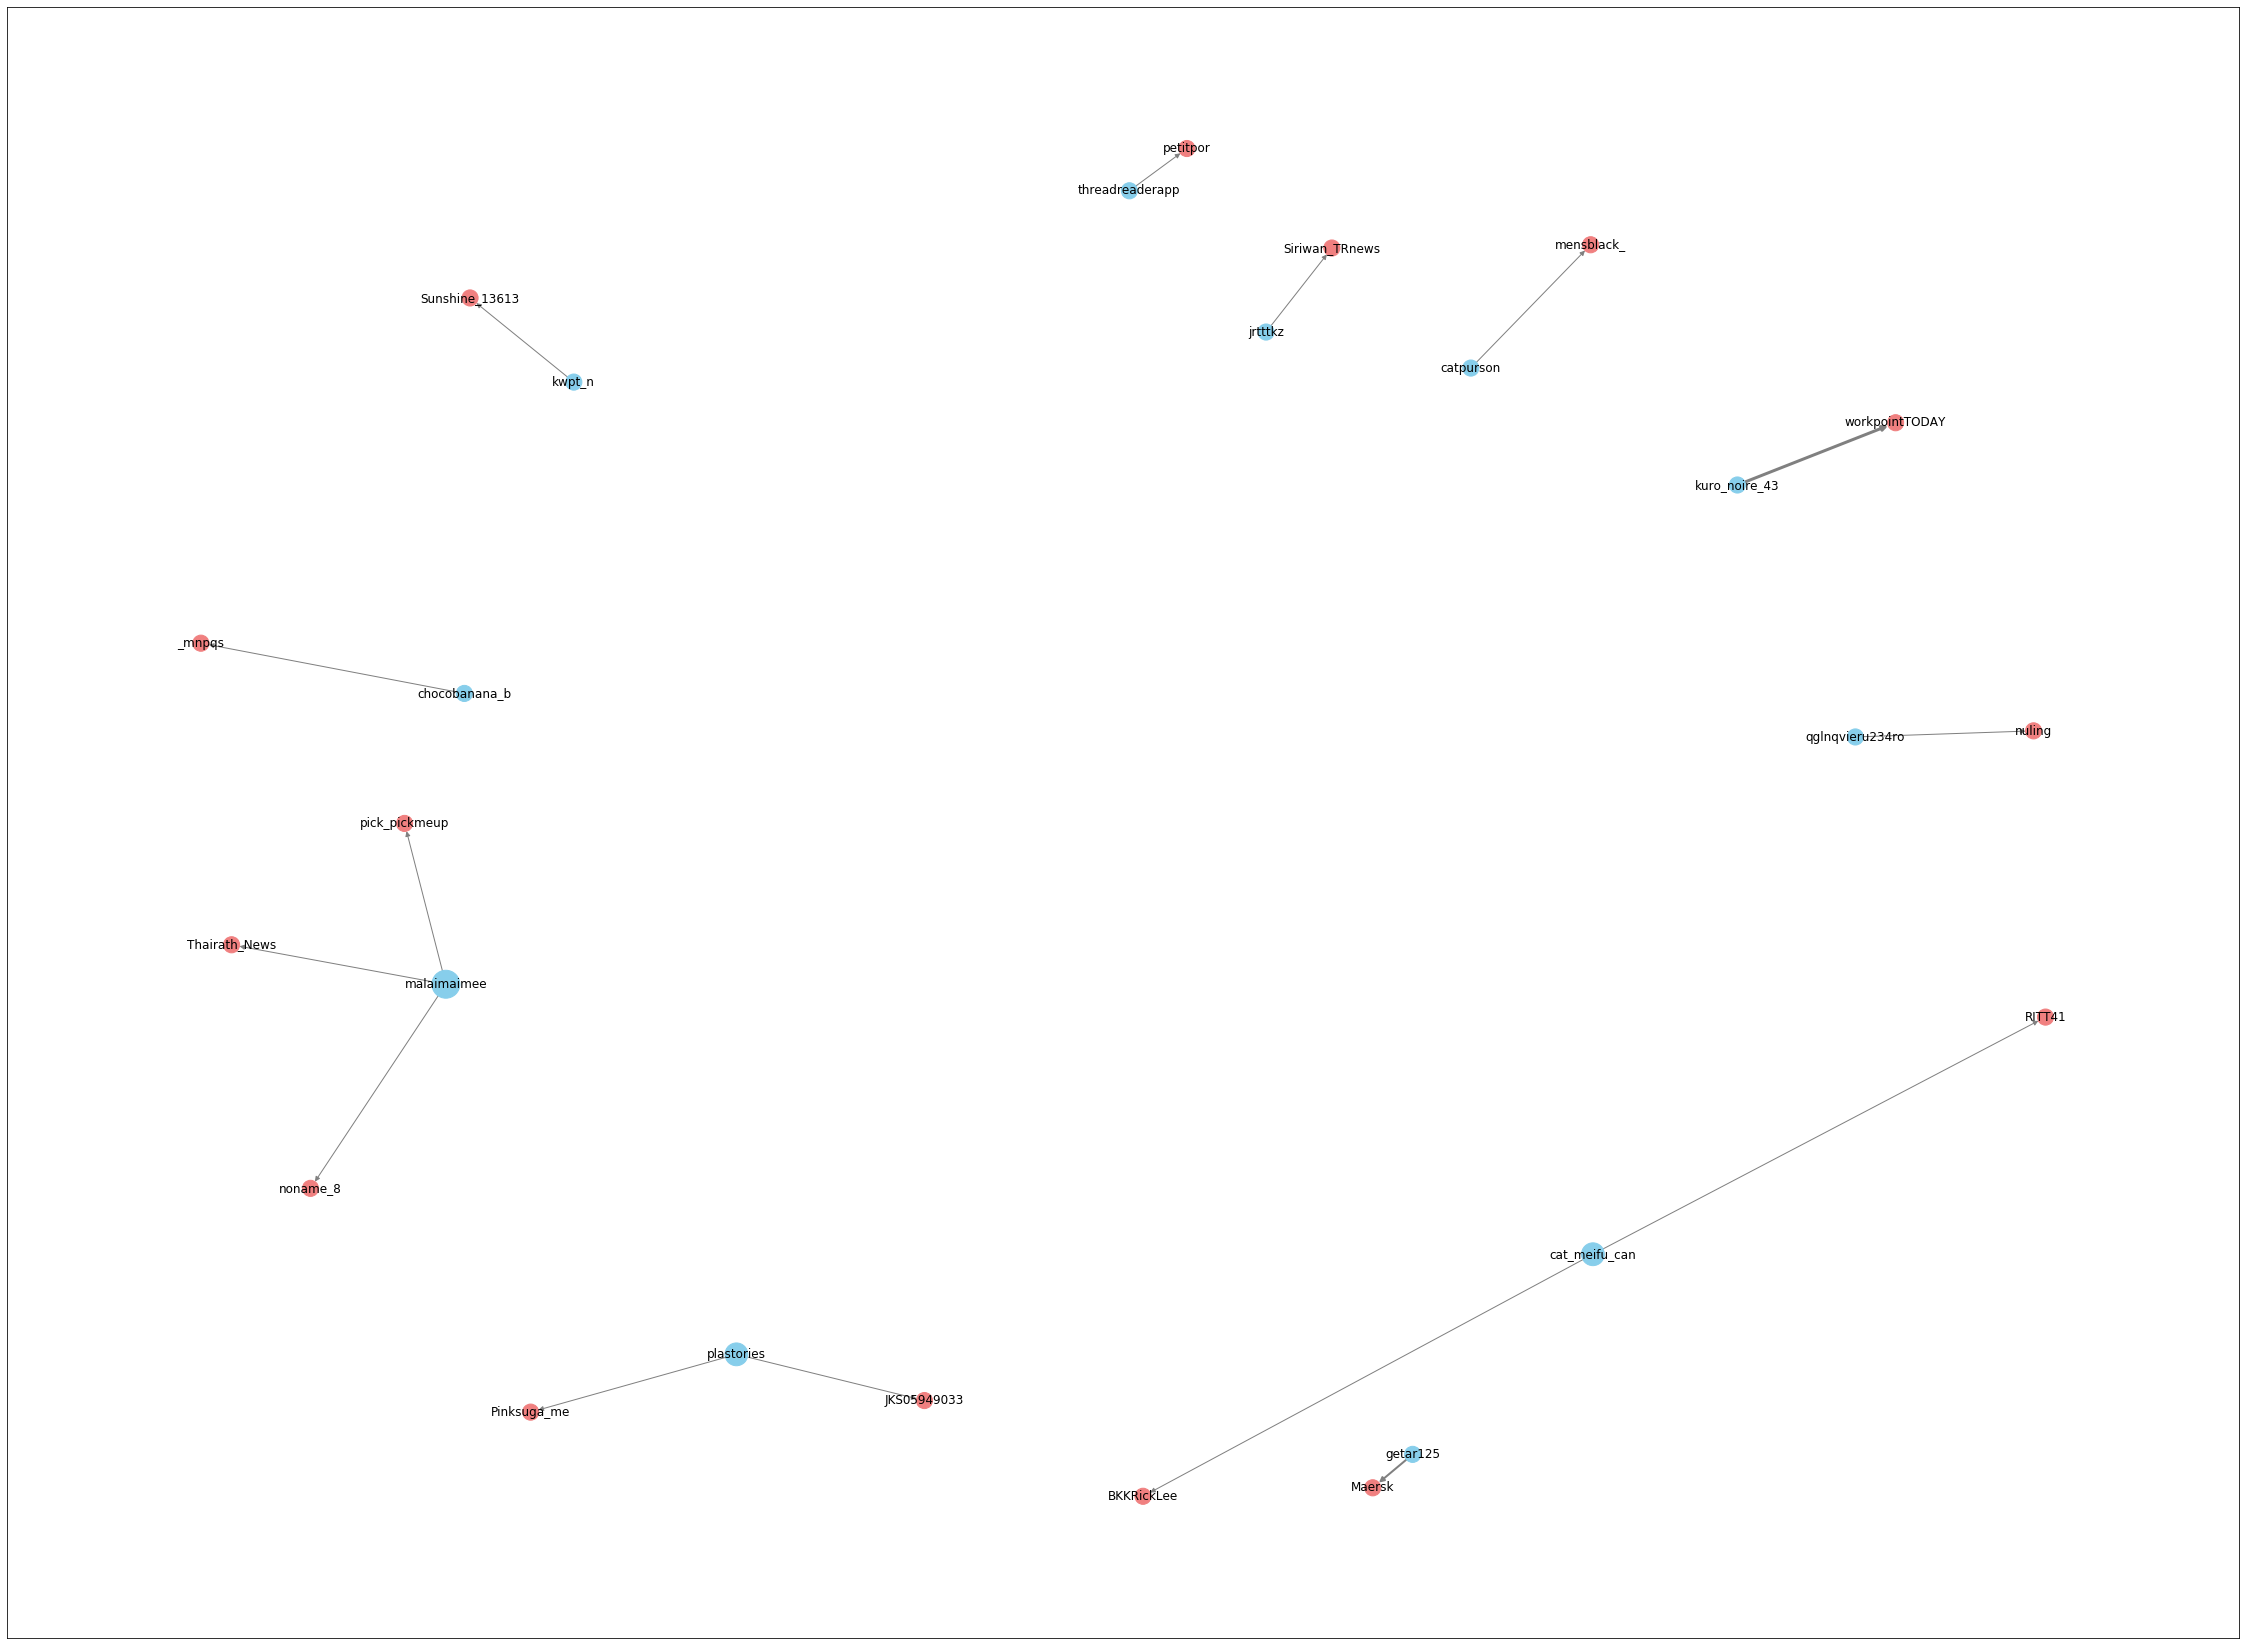

In [10]:
plt.figure(figsize=(40,30))
#pos = nx.circular_layout(G)
nx.draw_networkx(G, with_labels = True, node_color=node_color, edge_color="gray", node_size=sizes, width=edge_width)
plt.show()

In [107]:
node_to_remove = set()
for node, deg in G.degree():
    if deg <= 1:
        neighbor = list(G.predecessors(node)) + list(G.successors(node))
        neighbor_deg = G.degree()(neighbor[0])
        if neighbor_deg == 1:
            node_to_remove.add(node)
            node_to_remove.add(neighbor[0])
            
for node in node_to_remove:
    G.remove_node(node)

In [108]:
#cluster

nx.nx_agraph.view_pygraphviz(G, prog='fdp') 

('/var/folders/4s/mvdry9457txcvbj4wf_f36br0000gn/T/tmps4t5ubey.png',
 <AGraph <Swig Object of type 'Agraph_t *' at 0x7ff6e286b930>>)

In [26]:
# repliers

print("|replier|count|\n|:-:|:-:|")
i = 0
for name, count in reply.replier.value_counts().iteritems():
    print(f"|[@{name}](https://twitter.com/{name})|{count}|")
    i += 1
    if i >= 10:
        break

|replier|count|
|:-:|:-:|
|[@veishou1](https://twitter.com/veishou1)|63|
|[@sahtitbkk](https://twitter.com/sahtitbkk)|37|
|[@kamaladanvers](https://twitter.com/kamaladanvers)|24|
|[@serene332](https://twitter.com/serene332)|11|
|[@athena31102](https://twitter.com/athena31102)|11|
|[@wskuru](https://twitter.com/wskuru)|11|
|[@kaidee888](https://twitter.com/kaidee888)|10|
|[@cocala7](https://twitter.com/cocala7)|9|
|[@spectacud](https://twitter.com/spectacud)|8|
|[@nengnen72682670](https://twitter.com/nengnen72682670)|8|


In [27]:
# replyees

print("|replyee|count|\n|:-:|:-:|")
i = 0
for name, count in reply.replyee.value_counts().iteritems():
    print(f"|[@{name}](https://twitter.com/{name})|{count}|")
    i += 1
    if i >= 10:
        break

|replyee|count|
|:-:|:-:|
|[@FreeYOUTHth](https://twitter.com/FreeYOUTHth)|16|
|[@MatichonOnline](https://twitter.com/MatichonOnline)|16|
|[@charoenpura](https://twitter.com/charoenpura)|14|
|[@Maersk](https://twitter.com/Maersk)|13|
|[@tanawatofficial](https://twitter.com/tanawatofficial)|11|
|[@johnwinyu](https://twitter.com/johnwinyu)|9|
|[@AmaratJeab](https://twitter.com/AmaratJeab)|8|
|[@KhaosodOnline](https://twitter.com/KhaosodOnline)|8|
|[@thestandardth](https://twitter.com/thestandardth)|7|
|[@TSererak](https://twitter.com/TSererak)|7|


In [20]:
G.add_node?

Signature: G.add_node(node_for_adding, **attr)
Docstring:
Add a single node `node_for_adding` and update node attributes.

Parameters
----------
node_for_adding : node
    A node can be any hashable Python object except None.
attr : keyword arguments, optional
    Set or change node attributes using key=value.

See Also
--------
add_nodes_from

Examples
--------
>>> G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
>>> G.add_node(1)
>>> G.add_node("Hello")
>>> K3 = nx.Graph([(0, 1), (1, 2), (2, 0)])
>>> G.add_node(K3)
>>> G.number_of_nodes()
3

Use keywords set/change node attributes:

>>> G.add_node(1, size=10)
>>> G.add_node(3, weight=0.4, UTM=("13S", 382871, 3972649))

Notes
-----
A hashable object is one that can be used as a key in a Python
dictionary. This includes strings, numbers, tuples of strings
and numbers, etc.

On many platforms hashable items also include mutables such as
NetworkX Graphs, though one should be careful that the hash
doesn't change on mutables.
Fi

In [25]:
nx.draw_networkx?

Signature: nx.draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
Docstring:
Draw the graph G using Matplotlib.

Draw the graph with Matplotlib with options for node positions,
labeling, titles, and many other drawing features.
See draw() for simple drawing without labels or axes.

Parameters
----------
G : graph
   A networkx graph

pos : dictionary, optional
   A dictionary with nodes as keys and positions as values.
   If not specified a spring layout positioning will be computed.
   See :py:mod:`networkx.drawing.layout` for functions that
   compute node positions.

arrows : bool, optional (default=True)
   For directed graphs, if True draw arrowheads.
   Note: Arrows will be the same color as edges.

arrowstyle : str, optional (default='-|>')
    For directed graphs, choose the style of the arrowsheads.
    See :py:class: `matplotlib.patches.ArrowStyle` for more
    options.

arrowsize : int, optional (default=10)
   For directed graphs, choose the size of the arrow 